# Half Life – Junior Customer Analytics Assignment

**Part 1 – Data Exploration & Cleaning**

In [4]:
# Importing basic libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
# Loading customer, transaction, and product datasets
customers = pd.read_csv('/content/customers.csv')
transactions = pd.read_csv('/content/transactions.csv')
products = pd.read_csv('/content/products.csv')


In [12]:
# Display the info for each dataset
print("--- Customers Info ---")
customers.info()
print("\n" + "="*30 + "\n")

print("--- Transactions Info ---")
transactions.info()
print("\n" + "="*30 + "\n")

print("--- Products Info ---")
products.info()


--- Customers Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        5000 non-null   object 
 1   registration_date  5000 non-null   object 
 2   email              4900 non-null   object 
 3   first_name         5000 non-null   object 
 4   last_name          5000 non-null   object 
 5   age                4950 non-null   float64
 6   gender             5000 non-null   object 
 7   city               5000 non-null   object 
 8   province           5000 non-null   object 
 9   country            5000 non-null   object 
 10  postal_code        5000 non-null   object 
 11  customer_segment   5000 non-null   object 
 12  marketing_consent  5000 non-null   bool   
dtypes: bool(1), float64(1), object(11)
memory usage: 473.8+ KB


--- Transactions Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 en

Check missing values

In [9]:
customers.isnull().sum()



,0
customer_id,0
registration_date,0
email,100
first_name,0
last_name,0
age,50
gender,0
city,0
province,0
country,0


In [10]:
transactions.isnull().sum()


,0
transaction_id,0
customer_id,0
transaction_date,0
product_id,0
quantity,0
unit_price,0
total_amount,0
discount_amount,0
payment_method,0
shipping_cost,0


In [11]:
products.isnull().sum()


,0
product_id,0
product_name,0
category,0
subcategory,0
brand,0
current_price,0
cost_price,0
stock_quantity,0
weight_kg,0
launch_date,0


In [13]:
# Fill missing ratings with the median
products['rating'] = products['rating'].fillna(products['rating'].median())
# Fill missing customer age with median
customers['age'] = customers['age'].fillna(customers['age'].median())
# Fill missing emails with 'unknown'
customers['email'] = customers['email'].fillna('Unknown')

# Convert all date columns to datetime objects
products['launch_date'] = pd.to_datetime(products['launch_date'])
customers['registration_date'] = pd.to_datetime(customers['registration_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [14]:
# Keep only completed orders for analysis
completed_txns = transactions[transactions['order_status'] == 'Completed']


In [15]:
# Define a reference date
reference_date = completed_txns['transaction_date'].max()


In [16]:
# Calculate total spend per customer
total_spend = completed_txns.groupby('customer_id')['total_amount'].sum().reset_index()
total_spend.rename(columns={'total_amount': 'total_spend'}, inplace=True)


In [17]:
# Calculate number of orders per customer
num_orders = completed_txns.groupby('customer_id')['transaction_id'].nunique().reset_index()
num_orders.rename(columns={'transaction_id': 'num_orders'}, inplace=True)


In [18]:
# Find the most recent purchase date for each customer
last_purchase = completed_txns.groupby('customer_id')['transaction_date'].max().reset_index()
last_purchase.rename(columns={'transaction_date': 'last_purchase_date'}, inplace=True)


In [19]:
# Merge all customer-level metrics into one table
customer_stats = total_spend.merge(num_orders, on='customer_id') \
                            .merge(last_purchase, on='customer_id')


In [20]:
# Calculate how many days since the customer last purchased
customer_stats['days_since_last_purchase'] = (
    reference_date - customer_stats['last_purchase_date']
).dt.days


In [21]:
# Calculate average order value
customer_stats['avg_order_value'] = (
    customer_stats['total_spend'] / customer_stats['num_orders']
)


In [24]:
tx_cust = transactions.merge(customers, on='customer_id', how='left')


In [25]:
full_data = tx_cust.merge(products, on='product_id', how='left')


In [33]:
full_data.head()



,transaction_id,customer_id,transaction_date,product_id,quantity,unit_price,total_amount,discount_amount,payment_method,shipping_cost,...,subcategory,brand,current_price,cost_price,stock_quantity,weight_kg,launch_date,is_active,rating,review_count
0,TXN0000013628,CUST000575,2023-09-21 15:02:53,PROD000153,1,191.62,191.62,0.00,PayPal,0.00,...,Educational,Classic,191.62,122.43,250,8.38,2019-03-30,True,3.9,22
1,TXN0000004499,CUST002669,2024-04-29 04:32:19,PROD000126,1,49.42,49.42,0.00,Apple Pay,10.24,...,Kitchen Tools,ActiveWear,49.42,15.74,223,8.26,2022-05-17,False,3.4,495
2,TXN0000012254,CUST003586,2024-05-30 12:37:47,PROD000142,1,276.48,261.37,15.11,Google Pay,0.00,...,Haircare,ProGear,276.48,103.88,119,2.44,2022-08-12,True,3.5,262
3,TXN0000001097,CUST004454,2024-10-04 10:30:30,PROD000106,3,211.40,634.20,0.00,Google Pay,0.00,...,Jackets,Deluxe,211.40,117.82,188,8.93,2019-05-30,True,4.4,96
4,TXN0000000438,CUST000978,2024-05-24 01:09:09,PROD000037,1,67.55,67.55,0.00,PayPal,0.00,...,Bedding,StyleMax,67.55,33.36,361,8.81,2020-12-01,True,4.1,378


In [29]:
customer_stats.head()

,customer_id,total_spend,num_orders,last_purchase_date,days_since_last_purchase,avg_order_value
0,CUST000000,812.22,3,2024-08-16 07:41:45,138,270.740000
1,CUST000002,257.16,3,2024-10-05 10:55:13,88,85.720000
2,CUST000003,835.86,4,2024-08-24 20:42:57,130,208.965000
3,CUST000004,2465.33,12,2024-11-24 20:27:19,38,205.444167
4,CUST000005,414.42,1,2024-08-29 18:13:12,125,414.420000


In [30]:
# Save customer analytics dataset for further analysis
customer_stats.to_csv('customer_analytics.csv', index=False)


In [32]:
# Save dataset for further analysis
full_data.to_csv('full_data.csv', index=False)

**Data Exploration, Cleaning, and Preparation Summary**

For this analysis, I first imported the required Python libraries and loaded the three datasets provided: customers.csv, transactions.csv, and products.csv. Before doing any analysis, I explored each dataset separately to understand their structure, data types, and purpose.

Understanding the datasets:

1.Customers dataset: Contains customer-level information such as customer ID, age, email, and registration date.

2.Transactions dataset: Contains transaction-level details including transaction ID, customer ID, product ID, transaction date, order status, quantity, and total amount.

3.Products dataset: Contains product-related information such as product ID, product name, category, subcategory, brand, price, and rating.

After understanding the datasets, I checked for missing values in each file. I found a small number of missing values in product ratings and customer age. Since only a few values were missing and these fields were not the main focus of the analysis, I chose to fill them using the median rather than the mean, as the median is less affected by extreme values. For missing customer email values, I replaced them with “Unknown” instead of removing records, because it is important to retain all customers for analysis. No rows were removed during cleaning. I also converted all date-related columns into datetime format to support time-based analysis later.

After cleaning, I prepared the data for analysis by creating two datasets for different purposes:

1.Transaction-level dataset (full_data): Created by merging transactions with customer and product information. This dataset is used for sales and product-level analysis, such as revenue trends and category performance.

2.Customer-level analytics dataset(customer_analytics): Created by aggregating transaction data to calculate total spend, number of orders, average order value, and days since last purchase for each customer. These features summarize customer purchasing behavior and are commonly used in customer segmentation and marketing analysis.

**Part 2 – Basic Customer Segmentation**

In [34]:
# Calculate thresholds using percentiles
spend_75 = customer_stats['total_spend'].quantile(0.75)
spend_40 = customer_stats['total_spend'].quantile(0.40)

orders_75 = customer_stats['num_orders'].quantile(0.75)
recency_75 = customer_stats['days_since_last_purchase'].quantile(0.75)


In [35]:
# Create a new column for customer segment
def assign_segment(row):
    if (row['total_spend'] >= spend_75) and (row['num_orders'] >= orders_75):
        return 'High-Value / Loyal'
    elif row['days_since_last_purchase'] >= recency_75:
        return 'Inactive'
    elif row['total_spend'] >= spend_40:
        return 'Regular'
    else:
        return 'Occasional'

customer_stats['customer_segment'] = customer_stats.apply(assign_segment, axis=1)


In [36]:
customer_stats['customer_segment'].value_counts()


,count
customer_segment,
Regular,1103
Inactive,894
High-Value / Loyal,828
Occasional,783


In [44]:
segment_summary = (
    customer_stats
    .groupby('customer_segment')
    .agg(
        number_of_customers=('customer_id', 'count'),
        avg_spend=('total_spend', 'mean'),
        avg_orders=('num_orders', 'mean')
    )
    .reset_index()
)

segment_summary


,customer_segment,number_of_customers,avg_spend,avg_orders
0,High-Value / Loyal,828,4369.326957,17.632850
1,Inactive,894,399.844474,1.640940
2,Occasional,783,281.420294,1.717752
3,Regular,1103,1031.470526,4.116047


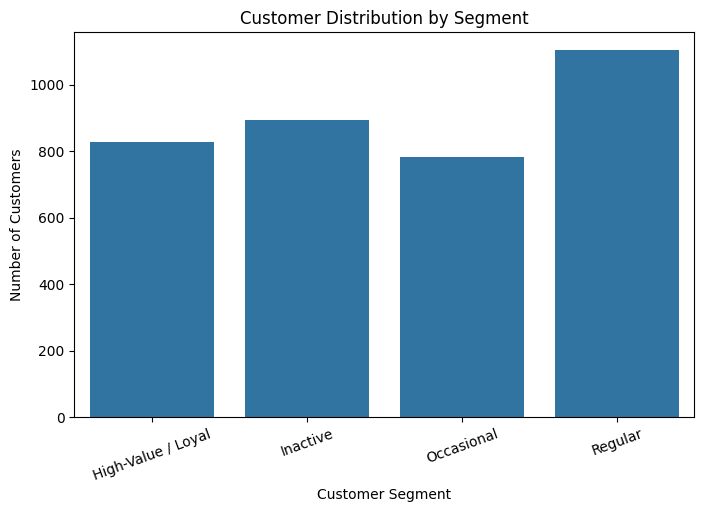

In [38]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=segment_summary,
    x='customer_segment',
    y='number_of_customers'
)
plt.title('Customer Distribution by Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=20)
plt.show()


**Part 3 – Basic Sales Analysis**

In [46]:
full_data['revenue'] = full_data['quantity'] * full_data['unit_price']

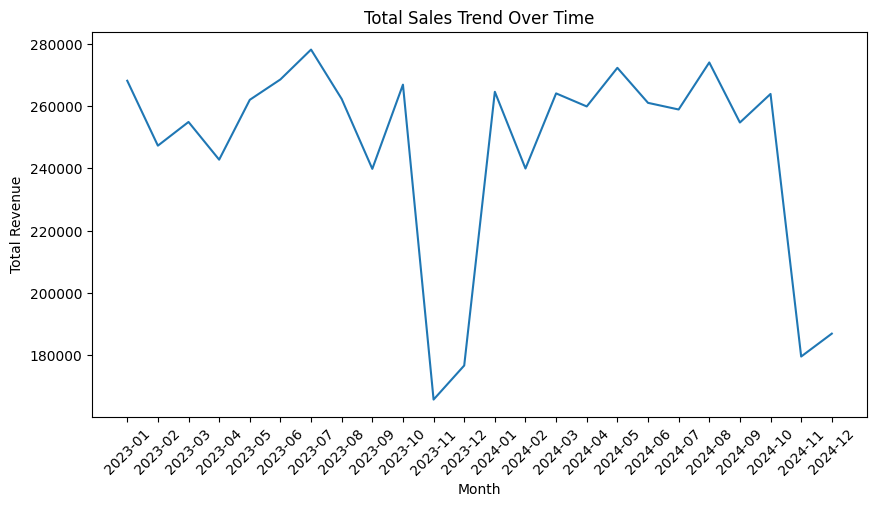

In [51]:
#Sales Trend Over Time
# Create month column
full_data['order_month'] = full_data['transaction_date'].dt.to_period('M').astype(str)

monthly_sales = (
    full_data
    .groupby('order_month')
    .agg(
        total_revenue=('revenue', 'sum'),
        number_of_orders=('transaction_id', 'nunique')
    )
    .reset_index()
)
plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_sales, x='order_month', y='total_revenue')
plt.title('Total Sales Trend Over Time')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()


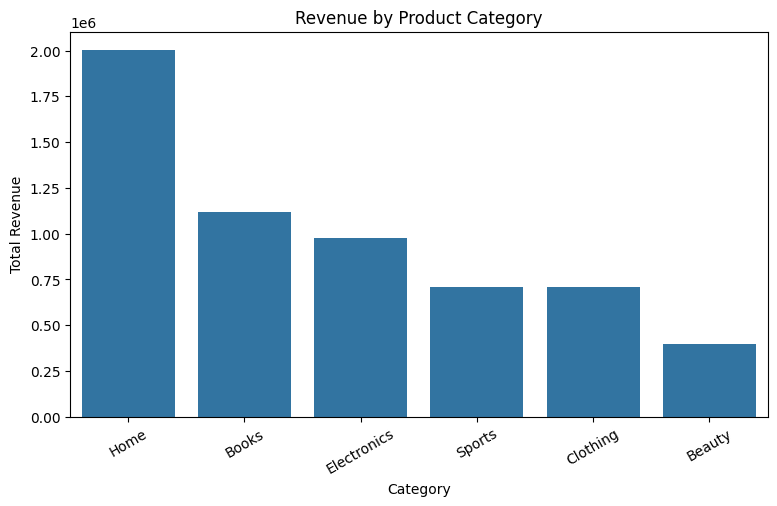

In [50]:
#Best Performing Product Categories
category_sales = (
    full_data
    .groupby('category')
    .agg(
        total_revenue=('revenue', 'sum'),
        number_of_orders=('transaction_id', 'nunique'),
        avg_order_value=('revenue', 'mean')
    )
    .reset_index()
    .sort_values(by='total_revenue', ascending=False)
)
plt.figure(figsize=(9,5))
sns.barplot(data=category_sales, x='category', y='total_revenue')
plt.title('Revenue by Product Category')
plt.xlabel('Category')
plt.ylabel('Total Revenue')
plt.xticks(rotation=30)
plt.show()



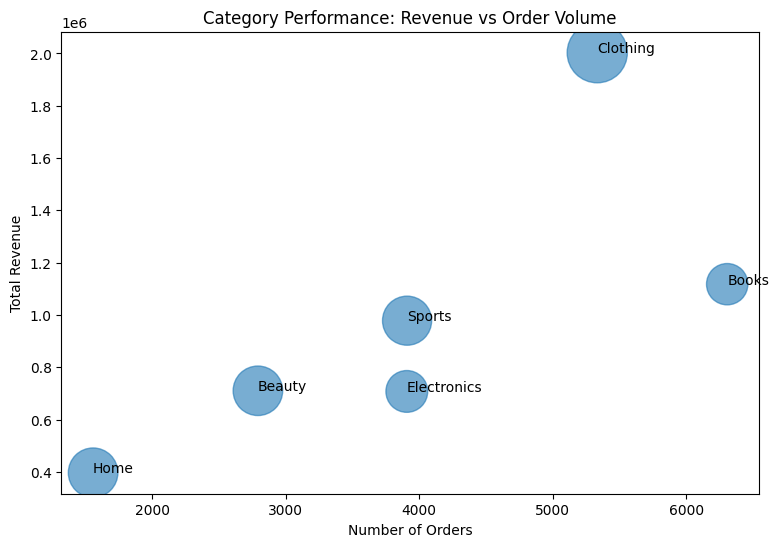

In [54]:
plt.figure(figsize=(9,6))
plt.scatter(
    category_sales['number_of_orders'],
    category_sales['total_revenue'],
    s=category_sales['avg_order_value'] * 5,
    alpha=0.6
)

for i, txt in enumerate(category_sales['category']):
    plt.annotate(txt, (
        category_sales['number_of_orders'][i],
        category_sales['total_revenue'][i]
    ))

plt.xlabel('Number of Orders')
plt.ylabel('Total Revenue')
plt.title('Category Performance: Revenue vs Order Volume')
plt.show()



**Sales Analysis – Key Findings & Insights**

In this sales analysis, I used three main metrics  revenue, number of orders, and average order value (AOV)  to understand how sales perform over time and across product categories.

1. Sales Trend Over Time

The monthly sales trend shows that revenue is generally stable across most months, with values staying around a similar range. However, there are a few noticeable changes. For example, sales drop sharply around October–November 2023, before recovering strongly in early 2024. Another decline is visible around November 2024, followed by a slight recovery in December 2024. These patterns suggest that sales fluctuations are likely influenced by seasonal factors, promotions, or changes in customer demand rather than long-term performance issues.


2. Revenue by Product Category

When analyzing revenue by product category, it is clear that Home is the strongest revenue-generating category, followed by Books and Electronics. Categories such as Sports and Clothing contribute a moderate amount, while Beauty generates the lowest total revenue.

This shows that customer spending is concentrated in a few categories rather than evenly distributed across all products.

3. Revenue vs Order Volume (Category Comparison)

Comparing revenue with order volume reveals an important insight. Books has a high number of orders but lower total revenue compared to Home, which generates much higher revenue with fewer orders. On the other hand, Clothing shows relatively high revenue with a moderate number of orders, indicating a higher average order value. This confirms that more orders do not always mean higher revenue.

One surprising finding was how strongly revenue is driven by a small number of categories, especially Home, while categories like Books rely more on volume rather than value.

**Key Recommendation**

The business should prioritize marketing and promotions for Home and Clothing, as these categories generate higher revenue per order. At the same time, strategies such as bundles or upselling could be tested in Books and Beauty to increase their average order value and overall contribution.